# Before your start with this Tutorial

**Tutorial Intention:** Providing an example of iteration and related step on a modeling phase for you to:

*   Experience the data science lifecycle using Vectice
*   See how simple it is to connect your notebook to Vectice
*   Learn how to structure and log your work using Vectice

**Resources needed:**
*   <b>Tutorial Project: Forecast in-store unit sales (22.4)</b> - You can find it as part of your personal workspace named after your name
*   Dataset ready for modeling: https://vectice-examples.s3.us-west-1.amazonaws.com/Tutorial/ForecastTutorial/train_clean.csv
*   Vectice Webapp Documentation: https://docs.vectice.com/
*   Vectice API documentation: https://api-docs.vectice.com/sdk/index.html

## Installing Vectice

In [123]:
!pip3 install --q vectice[git]
!pip3 show vectice

87327.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
87334.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Name: vectice
Version: 22.4.9.0
Summary: Vectice Python library
Home-page: https://www.vectice.com
Author: Vectice Inc.
Author-email: sdk@vectice.com
License: Apache License 2.0
Location: /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages
Requires: Deprecated, gql, python-dotenv, requests, requests-toolbelt, urllib3
Required-by: 


## Install optional packages for your project

In [124]:
!pip3 install --q squarify
!pip3 install --q plotly

87340.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
87347.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


## Import libraries

In [140]:
# importing mathematical and ds libraries
import pandas as pd  # data science essentials
import matplotlib.pyplot as plt  # essential graphical output
import numpy as np   # mathematical essentials
%matplotlib inline

# import Visual libraries
import plotly.offline as py
py.init_notebook_mode(connected=True)
from matplotlib import pyplot as plt
#import seaborn as sns  # enhanced graphical output

#importing other libraries
import IPython.display #this is for our data pipeline
import logging
logging.basicConfig(level=logging.INFO)

# Load scikit-learn packages for modeling
from sklearn.model_selection import train_test_split #Split function
from sklearn.linear_model import LinearRegression #LR function
from sklearn.metrics import mean_squared_error,mean_absolute_error

#import the Vectice Library
import vectice
from vectice import FileDataWrapper

##  Vectice Config     
- To log your work to Vectice, you need to connect your notebook to your profile using your personal API token       
- Click on your profile at the top right corner of the Vectice application --> API Tokens --> Create API Token       
- Provide a name and description for the key. We recommend you name the API Token: "Tutorial_API_Token" to avoid having to make additional changes to the notebook.
- Save it in a location accessible by this code

### Update the workspace name below to match the workspace name your project is in

In [142]:
my_vectice = vectice.connect(config=r"Tutorial_API_token.json")
# print(my_vectice.workspaces) # print out a list of workspaces we have access to

my_workspace = my_vectice.workspace("Retail Ops") # replace workspace name
# print(my_workspace.projects) # print out a list of projects we have access to

my_project = my_workspace.project(".Forecast in-store unit sales")

2022/12/06 17:53:14 INFO vectice.connection: Vectice successfully connected.
2022/12/06 17:53:16 INFO vectice.connection: 
Last Used Assets
Project: Eric
Phase: My phase
Iteration: 276
IterationStep: Format Data


[Workspace(name=.ebarre, id=12, description=This is my workspace), Workspace(name=Adv. Analytics, id=62, description=Projects for the advanced analytics team.), Workspace(name=Call Center Projects, id=4, description= ), Workspace(name=Cyber, id=60, description=Cyber security projects), Workspace(name=Finance Team, id=58, description=Projects for the finance team), Workspace(name=Fraud, id=61, description=Projects related to HR topic like employee sentiment analysis), Workspace(name=HR Team, id=57, description=Projects related to HR topic like employee sentiment analysis), Workspace(name=Marketing Projects, id=59, description=Project related to marketing and customer segmentation.), Workspace(name=Retail Ops, id=17, description=Workspace for all projects for the Retail group.), Workspace(name=Templates, id=19, description=), Workspace(name=Tutorial, id=65, description=My personal workspace)]


2022/12/06 17:53:18 INFO vectice.models.workspace: Your current project: 65


## Capture milestones for the Modeling phase

In [143]:
# We are looking to create a new model in our "Modeling" phase
modeling = my_project.phase("Modeling")

# Let's start working by starting a new iteration for the Modeling Phase
modeling_iter = modeling.iteration



2022/12/06 17:53:53 INFO vectice.models.phase: Iteration with id: 277 successfully retrieved.


In [144]:
# Let's start working by starting a new iteration for the Modeling Phase
modeling_iter = modeling.iteration

#Let's have a look at all the steps defined in this phase
modeling_iter.step_names

2022/12/06 17:54:17 INFO vectice.models.phase: Iteration with id: 277 successfully retrieved.


['Select Modeling Techniques',
 'Generate Test Design',
 'Build Model',
 'Assess model']

In [145]:
# Let's pick the first step
modeling_step = modeling_iter.step("Select Modeling Techniques")

# Here we are documenting the modeling technique that we will use on this iteration
modeling_step.close(message="For this first iteration we are going to use a Linear Regression model to get a base model.")

# Let's get the next step in the process
modeling_step = modeling_iter.step("Generate Test Design")

2022/12/06 17:54:52 INFO vectice.models.iteration: Step: Select Modeling Techniques successfully retrieved.
2022/12/06 17:54:53 INFO vectice.models.step: 'Select Modeling Techniques' was successfully closed.
2022/12/06 17:54:53 INFO vectice.models.iteration: Step: Generate Test Design successfully retrieved.


# Linear Regression Model

## Generate Test Design

* Dataset ready for modeling: https://vectice-examples.s3.us-west-1.amazonaws.com/Tutorial/ForecastTutorial/train_clean.csv     

     Alternatively, you can generate the dataset from the Data_Preparation code.

In [146]:
#read the dataset
model_ds =pd.read_csv("train_clean.csv")

# Set split sizes
test_size = 0.20
# We will set the random seed so we always generate the same split.
random_state = 42

train, test = train_test_split(model_ds, test_size = test_size, random_state = random_state)

# Generate X_train, X_test, y_train, y_test, which we will need for modeling
X = model_ds.drop(['unit_sales'], axis=1)
y = model_ds["unit_sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Generate our 2 new datasets for training and testing
# train.to_csv("train_lr.csv")
# test.to_csv("test_lr.csv")

In [147]:
model_ds=model_ds.fillna(0) 

In [148]:
# Capture all the datasets that are used or generated by the model
my_project.origin_dataset = FileDataWrapper(path="train_clean.csv", name="Dataset ready for modeling")
my_project.origin_dataset = FileDataWrapper(path="train_lr.csv", name="Train Dataset for Linear Regression")
my_project.origin_dataset = FileDataWrapper(path="test_lr.csv", name="Test Dataset for Linear Regression")

2022/12/06 17:56:51 INFO vectice.models.datasource.datawrapper.file_data_wrapper: File: train_clean.csv wrapped successfully.
The code commit exists already.
2022/12/06 17:56:54 INFO vectice.api.client: Successfully registered Dataset(name='Dataset ready for modeling', id=779, version='Version 2', type=ORIGIN).
2022/12/06 17:56:55 INFO vectice.models.project: Successfully added Dataset(name='Dataset ready for modeling', id=779, version='Version 2', type=ORIGIN) to Generate Test Design
2022/12/06 17:56:55 INFO vectice.models.datasource.datawrapper.file_data_wrapper: File: train_lr.csv wrapped successfully.
2022/12/06 17:56:57 WARNING vectice.models.project: The code commit exists already.
2022/12/06 17:56:58 INFO vectice.api.client: Successfully registered Dataset(name='Train Dataset for Linear Regression', id=771, version='Version 3', type=ORIGIN).
2022/12/06 17:56:58 INFO vectice.models.project: Dataset: Train Dataset for Linear Regression with Version: Version 3 already exists.
2022/

In [149]:
# Now that we completed this step, let's close it with a message to let our coworker know what we achieved in the webb app
# modeling_step.close(message="With our improved linear regression we expect better results on the RSME and the MAE as some tuning has been done and this is not a row linear regression anymore")
modeling_step = modeling_step.next_step(message="With our improved linear regression we expect better results on the RSME and the MAE as some tuning has been done and this is not a row linear regression anymore")

2022/12/06 17:57:52 INFO vectice.models.step: 'Generate Test Design' was successfully closed.
2022/12/06 17:57:52 INFO vectice.models.step: Next step : Step(name='Build Model', id=1106, description='Set parameters for the model, add model description, run model', completed=False)


## Build Model

In [134]:
# Get the Build Model step
# The next step was already acquired above no need to 
# modeling_step = modeling_iter.step("Build Model")

### Linear Regression

In [150]:
#Lets create a linear regression model
model = LinearRegression()

model.fit(X_train.values, y_train.values)
    
pred = model.predict(X_test.values)

print(f"predicted responses:\n {pred}")
    
RMSE = np.sqrt(mean_squared_error(y_test.values, pred))
MAE = mean_absolute_error(y_test.values, pred)

print("root_mean_squared_error: ",RMSE) 
print("mean_absolute_error: ", MAE)

metrics = {"RMSE": RMSE, "MAE": MAE}

predicted responses:
 [-0.11031261  0.24907134  0.13587322 ... -0.03696472 -0.00967151
 -0.20251666]
root_mean_squared_error:  0.5584666828901371
mean_absolute_error:  0.1792399090212613


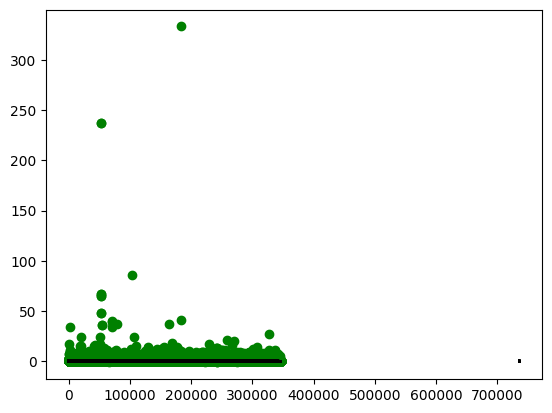

In [151]:
plt.scatter(X_train.iloc[:,0].values, y_train ,color='g') 
plt.plot(X_test, pred,color='k') 
plt.savefig("regression_graph.png")
plt.show()

In [152]:
# Let's log the model we trained along with its metrics, as a new version of the "Regression" model in Vectice.

# Get the Build Model step
# modeling_step = modeling_iter.step("Build Model")
modeling_iter.model = vectice.Model(name="Unit Sales Predictor", library="scikit-learn", technique="linear regression", metrics=metrics, attachments="regression_graph.png", predictor=model)
modeling_step.close(message="RMSE= " + str(metrics["RMSE"]) +  " and MAE= " + str(metrics["MAE"])) 

2022/12/06 17:59:14 WARNING vectice.models.iteration: The code commit exists already.
INFO:AttachmentApi:Attachment with name: regression_graph.png successfully attached to Model(name='Unit Sales Predictor', version='Version 7').
INFO:AttachmentApi:Model LinearRegression successfully attached to Model(name='Unit Sales Predictor', version='Version 7').
2022/12/06 17:59:18 INFO vectice.models.iteration: Successfully registered Model(name='Unit Sales Predictor', library='scikit-learn', technique='linear regression', version='Version 7').
2022/12/06 17:59:18 INFO vectice.models.iteration: Model: Unit Sales Predictor already exists.
2022/12/06 17:59:18 INFO vectice.models.iteration: Step: Generate Test Design successfully retrieved.
2022/12/06 17:59:19 INFO vectice.models.iteration: Successfully added Model(name='Unit Sales Predictor', version='Version 7') to Build Model
2022/12/06 17:59:19 INFO vectice.models.iteration: Successfully added Attachment: 641 from Model(name='Unit Sales Predict

## Assess Model

In [153]:
# Get the Collect Initial Data step
modeling_step = modeling_iter.step("Assess model")

2022/12/06 18:00:28 INFO vectice.models.iteration: Step: Assess model successfully retrieved.


In [154]:
modeling_step.close(message="As expected the model performs better however this is not good enough and we should try a different method. We recommend doing a Random Forest as a new iteration")

2022/12/06 18:00:31 INFO vectice.models.step: 'Assess model' was successfully closed.
